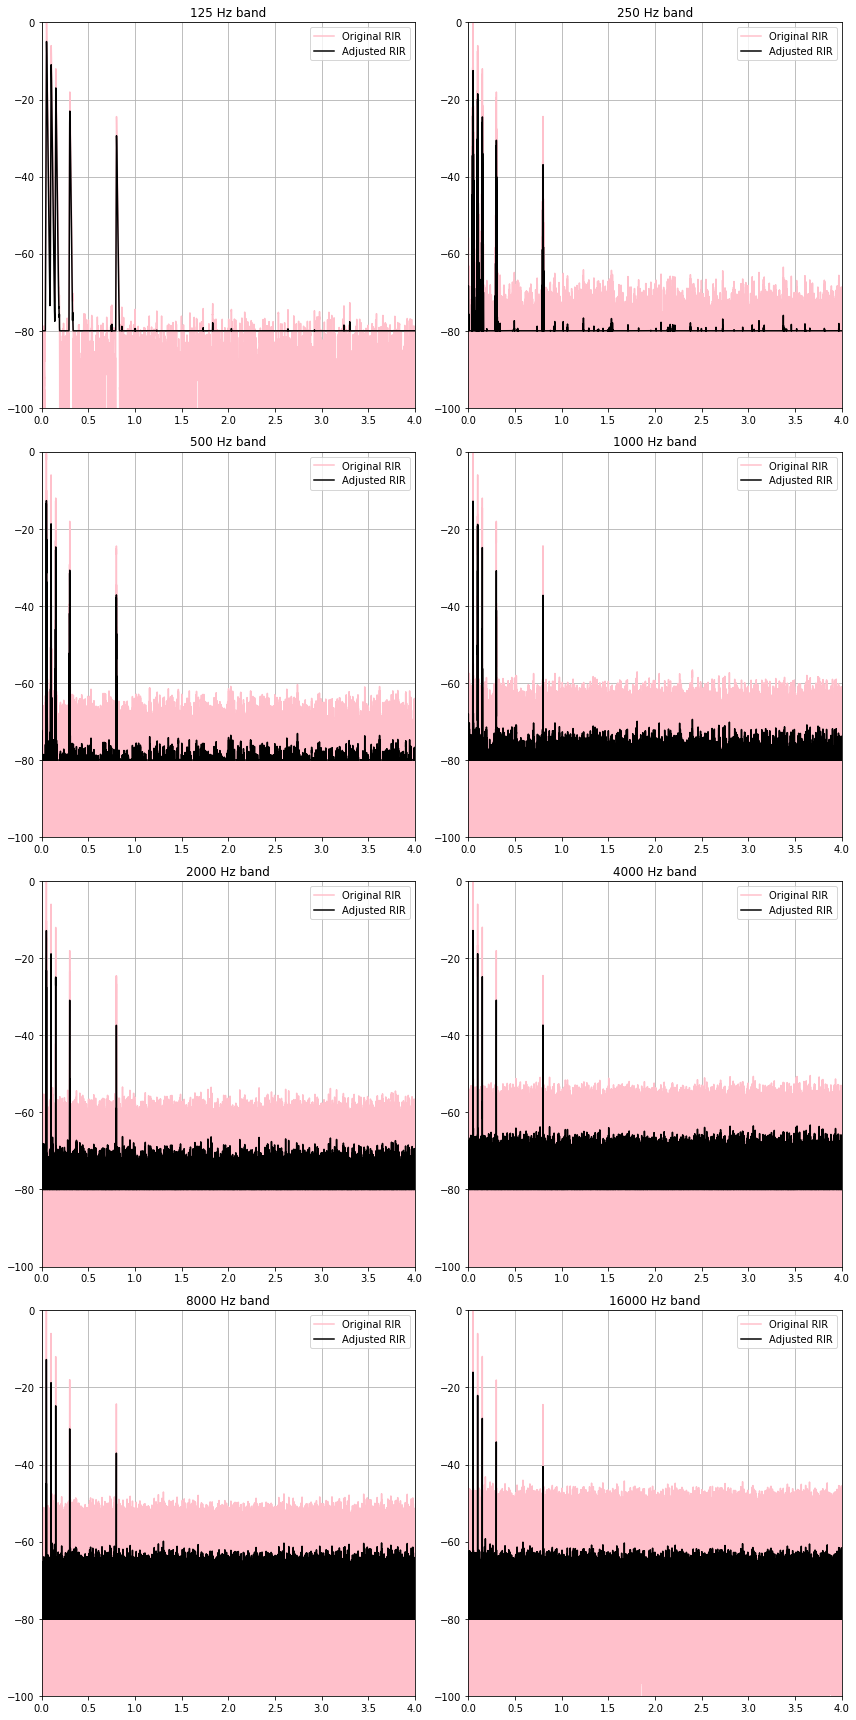

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Constants
fs = 44100  # Sampling frequency
duration = 4  # Duration of the RIR in seconds
t = np.linspace(0, duration, int(duration * fs), endpoint=False)

# Generate a synthetic RIR with distinct reflections
rir = np.zeros_like(t)
initial_decay = -0.005
reflections = [0.05, 0.1, 0.15, 0.3, 0.8]  # Reflection times in seconds
reflections_amplitudes = [1, 0.5, 0.25, 0.125, 0.06]  # Amplitudes of reflections
for r, amp in zip(reflections, reflections_amplitudes):
    rir += amp * np.exp(initial_decay * (t-r) * fs) * (t > r)
rir += np.random.normal(0, 0.0005, len(rir))  # Adding some noise

# Define octave band filters
def octave_band_filter(data, center_freq, fs, bandwidth_oct=1):
    b, a = butter(1, [((2 ** (bandwidth_oct / 2)) ** -1) * center_freq,
                      ((2 ** (bandwidth_oct / 2))) * center_freq], btype='band', fs=fs)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Octave band centers (standard)
octave_bands = [125, 250, 500, 1000, 2000, 4000, 8000, 16000]

# Plotting
fig, axs = plt.subplots(4, 2, figsize=(12, 24))

for i, ax in enumerate(axs.flatten()):
    # Apply filter to RIR
    if octave_bands[i] == 125:
        b, a = butter(1, octave_bands[i]/(fs/2), 'low')
    elif octave_bands[i] == 16000:
        b, a = butter(1, octave_bands[i]/(fs/2), 'high')
    else:
        b, a = butter(1, [((2 ** (1 / 2)) ** -1) * octave_bands[i],
                          ((2 ** (1 / 2))) * octave_bands[i]], btype='band', fs=fs)
    filtered_rir = filtfilt(b, a, rir)

    # Compute the squared magnitude in dB
    rir_squared = filtered_rir ** 2
    rir_db = 10 * np.log10(rir_squared / np.max(rir_squared))

    # Define noise floor and extrapolate decay through it
    noise_floor_db = -80
    noise_floor = 10 ** (noise_floor_db / 10)
    rir_db_adjusted = 10 * np.log10(np.maximum(rir_squared, noise_floor))

    # Plot original and adjusted RIR for each band
    ax.plot(t, rir_db, color='pink', label='Original RIR')
    ax.plot(t, rir_db_adjusted, color='black', label='Adjusted RIR')
    ax.set_title(f'{octave_bands[i]} Hz band')
    ax.set_ylim(-100, 0)
    ax.set_xlim(0, duration)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Level re: maximum (dB)')

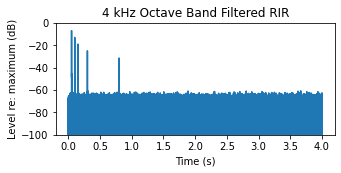

In [7]:
from scipy.signal import butter, lfilter

# Filter parameters
center_freq = 4000  # Center frequency for 4 kHz octave band
Q = 1/np.sqrt(2)  # Quality factor for octave band
lowcut = center_freq / np.sqrt(2)
highcut = center_freq * np.sqrt(2)

# Design a Butterworth bandpass filter
b, a = butter(N=1, Wn=[lowcut, highcut], btype='band', fs=fs)

# Apply the bandpass filter
filtered_rir_octave = lfilter(b, a, rir)

# Square and convert to dB
rir_octave_db = 10 * np.log10(filtered_rir_octave**2)

# Plot the filtered RIR in dB
plt.figure(figsize=(5, 7))
plt.subplot(3, 1, 1)
plt.plot(t, rir_octave_db)
plt.ylim([-100, 0])
plt.title('4 kHz Octave Band Filtered RIR')
plt.xlabel('Time (s)')
plt.ylabel('Level re: maximum (dB)')


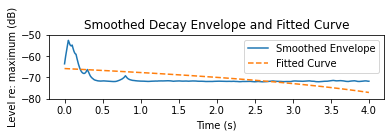

In [11]:
from scipy.signal import hilbert

# Calculate the envelope using the Hilbert transform
envelope = np.abs(hilbert(filtered_rir_octave))

# Smooth the envelope with a low-pass filter
b, a = butter(N=1, Wn=4/(0.5*fs), btype='low')
smoothed_envelope = filtfilt(b, a, envelope)

A = np.max(smoothed_envelope)
initial_decay_rate = -1 / (fs * 1.9) # Start with an estimated decay rate
noise_floor = np.mean(smoothed_envelope[-int(0.1*fs):]) # Estimate noise floor from the last 100 ms

def decay_model(t, decay_rate, noise_floor):
    return A * np.exp(decay_rate * t) + noise_floor

from scipy.optimize import curve_fit

popt, _ = curve_fit(decay_model, t, smoothed_envelope, p0=[initial_decay_rate, noise_floor])
plt.subplot(3, 1, 2)
plt.plot(t, 20 * np.log10(smoothed_envelope), label='Smoothed Envelope')
plt.plot(t, 20 * np.log10(decay_model(t, *popt)), label='Fitted Curve', linestyle='--')
plt.ylim([-80, -50])
plt.title('Smoothed Decay Envelope and Fitted Curve')
plt.xlabel('Time (s)')
plt.ylabel('Level re: maximum (dB)')
plt.legend()


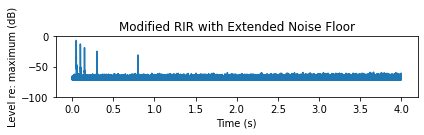

In [12]:
adjusted_decay_rate = -1 / (fs * 4.0)  # Target decay rate for 4.0 s reverberation time
adjusted_rir = filtered_rir_octave * np.exp((adjusted_decay_rate - popt[0]) * t)

# Extend the noise floor in the adjusted RIR
adjusted_rir_db = 10 * np.log10(adjusted_rir**2)
adjusted_rir_db_extended = np.where(adjusted_rir_db < 20 * np.log10(noise_floor),
                                    20 * np.log10(noise_floor), adjusted_rir_db)

# Plot the adjusted RIR
plt.subplot(3, 1, 3)
plt.plot(t, adjusted_rir_db_extended)
plt.ylim([-100, 0])
plt.title('Modified RIR with Extended Noise Floor')
plt.xlabel('Time (s)')
plt.ylabel('Level re: maximum (dB)')

plt.tight_layout()
plt.show()

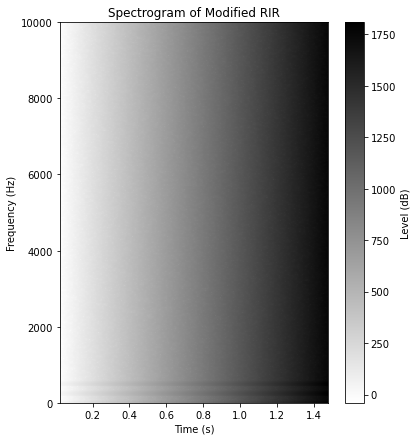

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Generate a more complex RIR or load your detailed RIR here
fs = 48000  # Sampling rate
t = np.linspace(0, 1.5, int(1.5 * fs), endpoint=False)  # 1.5 seconds
rir = np.exp(-3*t) * (np.sin(2 * np.pi * 250 * t) + np.sin(2 * np.pi * 500 * t) + np.random.normal(0, 0.05, len(t)))

# Process RIR for infinite reverberation simulation
rir_infinite_reverb = rir * np.exp(0.003 * np.arange(len(rir)))

# Generate the spectrogram
frequencies, times, Sxx = spectrogram(rir_infinite_reverb, fs=fs, window='blackmanharris', nperseg=2400, noverlap=int(0.95 * 2400), scaling='spectrum')

# Plot the spectrogram
plt.figure(figsize=(6, 7))
db_sxx = 10 * np.log10(Sxx)  # Convert power to dB
db_sxx = np.clip(db_sxx, -40, np.max(db_sxx))  # Clip dB to enhance contrast
plt.pcolormesh(times, frequencies, db_sxx, shading='auto', cmap='gist_yarg')
plt.colorbar(label='Level (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram of Modified RIR')
plt.ylim(0, 10000)  # Frequency limit for visibility
plt.show()
